# **PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle**

## 0. Постановка задачи


**Проблема:** 

Представим, что мы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

**Цель проекта:** построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля.

**Задачи проекта:**

* ознакомиться с входными данными
* изучить пример машинного обучения
* выполнить подготовку данных, которые будут использованы для обучения модели
* проверить эффективность предлагаемой модели, используя метрику MAPE
* принять участие в соревнованиях на площадке kaggle.com

## 1. Знакомимся с данными

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

### Импортируем библиотеки и загружаем данные

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # линейная алгебра
import pandas as pd # библиотека Pandas
import plotly.express as xp
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
nltk.download('vader_lexicon')
! pip install twython
from category_encoders import  OneHotEncoder, OrdinalEncoder
import geopy.distance

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\evgen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


You should consider upgrading via the 'C:\Users\evgen\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [57]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [58]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [59]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('Data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('Data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('Data/submission.csv') # самбмишн

In [60]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\evgen\AppData\Local\Temp\ipykernel_368524\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [62]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


In [63]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [64]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0


In [65]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [66]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## 2. EDA и проектирование признаков

### Название отеля

In [68]:
# исследуем данные о названии на наличие пропусков и дубликатов:
pivot_n = data[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name'
).nunique()

In [69]:
name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
mask = data['hotel_name'].isin(name_rep)
addresses_rep = data[mask][['hotel_name', 'hotel_address']].value_counts()

# чтобы различать эти отели при анализе - добавим в название город:
data['hotel_name'] = data.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

In [70]:
# выделим топ лучших по рейтингу, с порогом в 100 отзывов:
hotels_names = data.groupby('hotel_name')['average_score'].agg(
    ['mean', 'count'])

mask = (hotels_names['mean'] >= 9.0) & (hotels_names['count'] >= 100)
hotels_top = hotels_names[mask]

data['hotel_cat'] = data['hotel_name'].apply(
    lambda x: x if x in hotels_top.index else 'other')

# применим порядковое кодирование:
ord_encoder = OrdinalEncoder()
data['hotel_cat'] = data['hotel_cat'].astype('category')
hotels_bin = ord_encoder.fit_transform(data['hotel_cat'])
data = pd.concat([data, hotels_bin], axis=1)

# удалим исходный столбец
col = data.columns.tolist()
col[19] = 'hotel_code'

data.set_axis(col, axis=1, inplace=True)
data.drop('hotel_cat', axis=1, inplace=True);

### Адрес

In [71]:
addresses = pd.Series(data['hotel_address'].unique())

In [72]:
countries = addresses.apply(lambda x: x.split()[-1])
countries = countries.apply(
    lambda x: 'United Kingdom' if x == 'Kingdom' else x)

cities = addresses.apply(lambda x: x.split()[-2])
cities = cities.apply(lambda x: 'London' if x == 'United' else x)

addresses = pd.DataFrame(
    {'address': addresses, 'country': countries, 'city': cities})

data['hotel_country'] = data['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

# кодируем информацию о стране:
data['hotel_country'] = data['hotel_country'].astype('category')
data['hotel_country_code'] = data['hotel_country'].cat.codes

### Почтовый индекс

In [73]:
def get_postcode(address):
    """Извлечение почтового индекса из строки с адресом."""
    address_list = address.split()
    postcode_place = {
        'Kingdom': -4, 
        'Spain': -3, 
        'France': -3, 
        'Austria': -3, 
        'Netherlands': -4, 
        'Italy': -3
    }
    postcode = str(address_list[postcode_place[address_list[-1]]])
    
    if address_list[-1] == 'Kingdom' and postcode[-1].isalpha():
        return postcode[:-1]
    else:
        return postcode

    
# добавим почтовый индекс отеля как идентификатор района:
data['hotel_postcode'] = data['hotel_address'].apply(get_postcode)

In [74]:
#Удаляем признак с адресом
data.drop('hotel_address', axis=1, inplace=True)

### Широта и долгота

In [75]:
without_coor = len(data[data.isnull().any(1)]['hotel_postcode'].value_counts())

# вычисляем средние значения координат для каждого района:
pivot_coor = pd.pivot_table(
    data, 
    index='hotel_postcode', 
    values=['lat', 'lng'], 
    dropna=True, 
    aggfunc='mean')

data['lat'] = data.apply(
    lambda row: pivot_coor['lat'][row['hotel_postcode']] \
    if np.isnan(row['lat']) else row['lat'], axis=1)
data['lng'] = data.apply(
    lambda row: pivot_coor['lng'][row['hotel_postcode']] \
    if np.isnan(row['lng']) else row['lng'], axis=1)

In [76]:
# для формирования нового признака нужны координаты центра каждого города 
# (с сайта: https://dateandtime.info/):
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')


def get_dist_to_center(country, lng, lat):
    """Вычисление дистанции до центра города по координатам."""
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km

hotels_unique = data[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_unique['hotel_distance_to_center'] = hotels_unique.apply(
    lambda row: get_dist_to_center(row['hotel_country'], row['lng'], row['lat']), axis=1)

hotels_unique.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)
data = data.merge(hotels_unique, how='left', on='hotel_name', sort=False)

# теперь столбцы с координатами можно удалить:
data.drop(['lng', 'lat'], axis=1, inplace=True)

data[['hotel_name', 'hotel_distance_to_center']][:15]

,hotel_name,hotel_distance_to_center
0,Hotel Da Vinci,7.837768
1,Urban Lodge Hotel,6.243807
2,Alexandra Barcelona A DoubleTree by Hilton,0.563942
3,Hotel Principe Di Savoia,1.873428
4,Hotel Esther a,0.403517
5,Holiday Inn London Bloomsbury,1.736017
6,Holiday Inn London Wembley,18.456624
7,Novotel London West,10.595126
8,Hotel Saint Petersbourg Opera,3.099631
9,St George Hotel,3.765648


### Признаки "Review_date" and "Days_since_review"

In [77]:
# Приводим признак даты к подходящему типу
data.review_date = pd.to_datetime(data['review_date'])

data[data.review_date == data.review_date.max()]['days_since_review'].head(3)

1012    0 days
1706    0 days
2797    0 days
Name: days_since_review, dtype: object

In [78]:
data.drop('days_since_review', axis=1, inplace=True)

In [79]:
# Определяем, в каком месяце был написан отзыв
data.review_date = pd.to_datetime(data['review_date'], format='%Y-%m-%d').dt.month

data.rename(columns={'review_date':'review_month'}, inplace=True)
data.head(3)

,additional_number_of_scoring,review_month,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,sample,reviewer_score,hotel_code,hotel_country,hotel_country_code,hotel_postcode,hotel_distance_to_center
0,904,7,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",0,0.0,1,Italy,2,20161,7.837768
1,612,12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",0,0.0,1,Netherlands,3,1043,6.243807
2,46,11,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",0,0.0,1,Spain,4,08008,0.563942


<Axes:title={'center':'Зависимость между месяцем и оценкой'}, xlabel='review_month', ylabel='reviewer_score'>

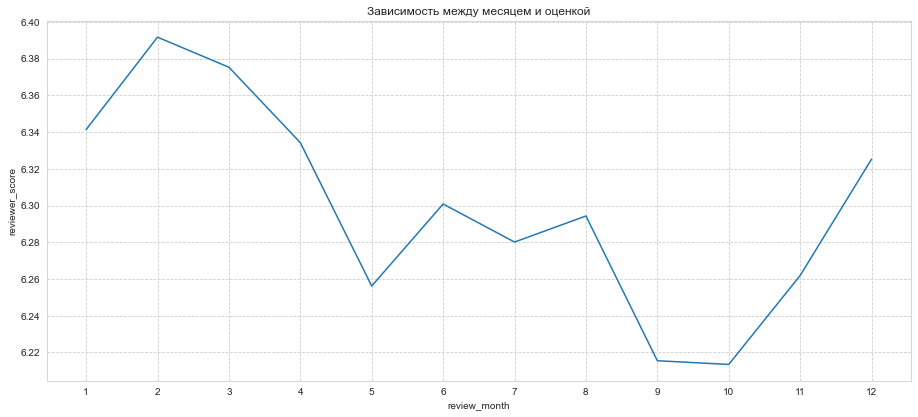

In [80]:
# Определяем наличие сезонности рейтинга
scores_grouped = data.groupby('review_month', as_index=False)['reviewer_score'].mean()

import matplotlib.ticker as ticker

fig = plt.figure(figsize = (12,5))
ax = fig.add_axes([1,1,1,1])
ax.set_title('Зависимость между месяцем и оценкой')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.lineplot(x=scores_grouped['review_month'], y=scores_grouped['reviewer_score'], ax=ax)

### Позитивные и негативные отзывы

In [81]:
# Анализируем положительные и отрицательные отзывы. Но перед этим преобразуем информацию
#Используется библиотека, которая умеет анализировать тон отзывов

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sent_analyzer = SentimentIntensityAnalyzer()

data['scores_p'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)) 

data['scores_n'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [82]:
display(data['scores_p'].head(5))

0    {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...
1    {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...
2    {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...
3    {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...
4    {'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...
Name: scores_p, dtype: object

In [83]:
# Создаём новые полученные признаки

data['positive_review_pos']  = data['scores_p'].apply(lambda x: x['pos'])
data['positive_review_neg']  = data['scores_p'].apply(lambda x: x['neg'])
data['positive_review_neu']  = data['scores_p'].apply(lambda x: x['neu'])
data['positive_review_compound']  = data['scores_p'].apply(lambda x: x['compound'])

data['negative_review_pos']  = data['scores_n'].apply(lambda x: x['pos'])
data['negative_review_neg']  = data['scores_n'].apply(lambda x: x['neg'])
data['negative_review_neu']  = data['scores_n'].apply(lambda x: x['neu'])
data['negative_review_compound']  = data['scores_n'].apply(lambda x: x['compound'])

data.head(3)

,additional_number_of_scoring,review_month,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,scores_p,scores_n,positive_review_pos,positive_review_neg,positive_review_neu,positive_review_compound,negative_review_pos,negative_review_neg,negative_review_neu,negative_review_compound
0,904,7,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...","{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...",0.329,0.000,0.671,0.9615,0.125,0.129,0.747,-0.0554
1,612,12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,"{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...","{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...",0.621,0.379,0.000,0.3400,0.000,0.216,0.784,-0.2960
2,46,11,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,"{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.740,0.000,0.260,0.6908,0.000,0.000,1.000,0.0000


### Корреляция

<AxesSubplot:title={'center':'Pearson correlation'}>

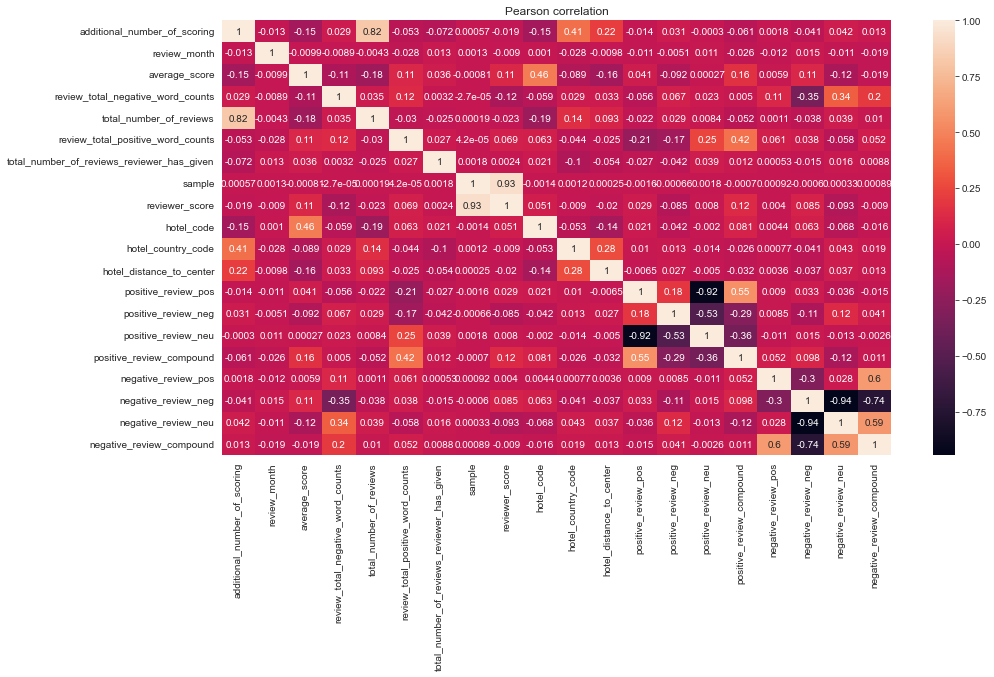

In [84]:
# Расчёт и визуализации корреляции
plt.figure(figsize = (15,8))
plt.title('Pearson correlation')
sns.heatmap(data.corr(), annot=True)

In [85]:
# Избавляемся от мультиколлинеарности
data.drop('additional_number_of_scoring', axis=1, inplace=True)
data.drop('negative_review_neg', axis=1, inplace=True)
data.drop('positive_review_neu', axis=1, inplace=True)

<AxesSubplot:title={'center':'Pearson correlation'}>

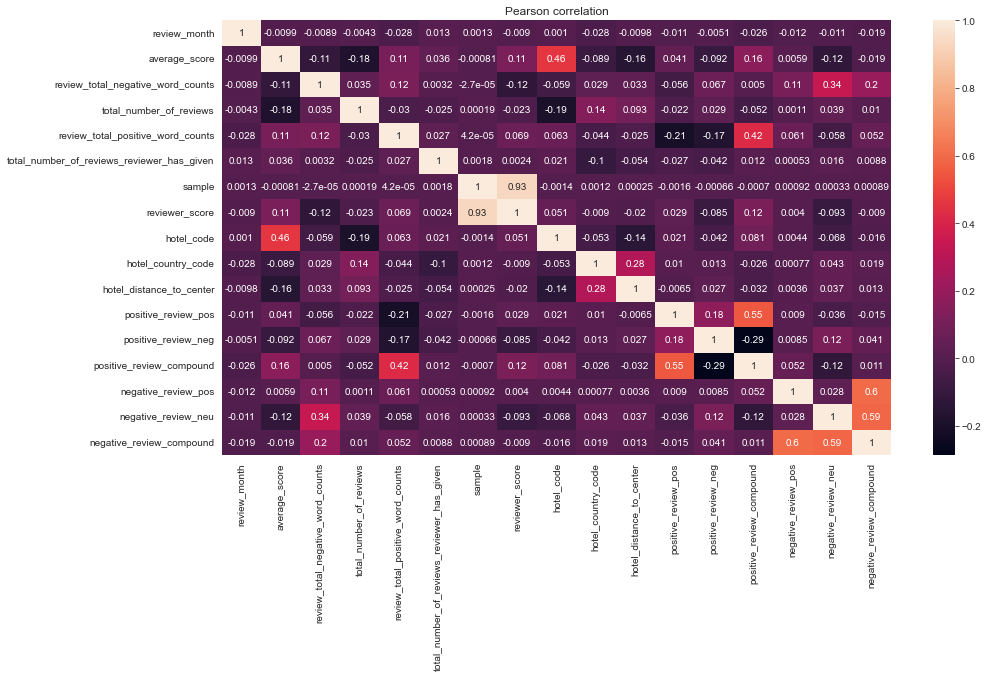

In [86]:
# Перепроверка
plt.figure(figsize = (15,8))
plt.title('Pearson correlation')
sns.heatmap(data.corr(), annot=True)

## 3. Подготовка модели

In [87]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" и "category" обучаться не будет, просто выберем их и удалим

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
category_columns = [s for s in data.columns if data[s].dtype.name == 'category'] 
data.drop(object_columns, axis = 1, inplace=True)
data.drop(category_columns, axis = 1, inplace=True)

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [90]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 33% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_SEED)

In [91]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 16), (386803, 16), (386803, 15), (259158, 15), (127645, 15))

In [92]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

## 4. Получаем результаты

In [93]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs = -1, random_state=RANDOM_SEED)

In [94]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


In [95]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических, выраженное в процентах.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1255883364503774


<AxesSubplot:>

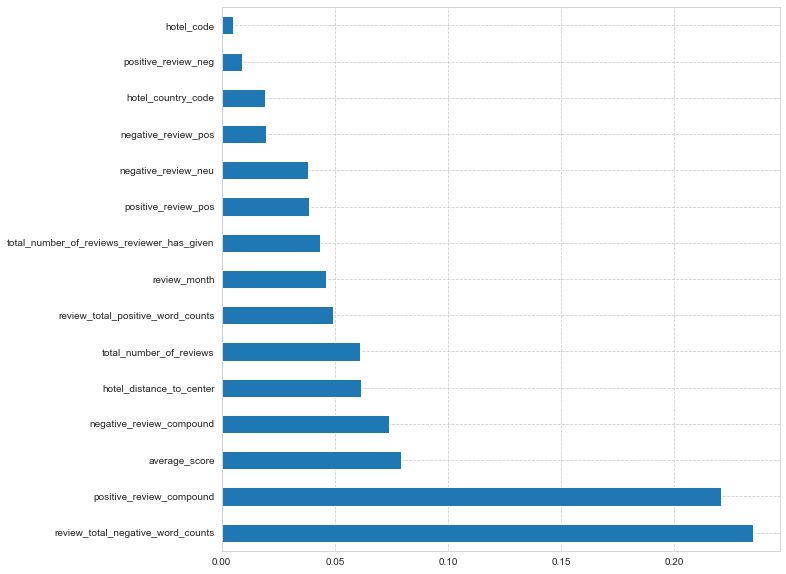

In [96]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [97]:
test_data.sample(10)

,review_month,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,hotel_code,hotel_country_code,hotel_distance_to_center,positive_review_pos,positive_review_neg,positive_review_compound,negative_review_pos,negative_review_neu,negative_review_compound
111500,2,8.7,28,1668,12,2,0.0,1,5,6.007864,0.518,0.000,0.8221,0.091,0.805,-0.1027
36244,7,8.4,6,2398,23,2,0.0,1,1,0.851898,0.293,0.000,0.8519,0.378,0.622,0.2075
3690,2,8.2,42,2996,22,1,0.0,1,5,4.552053,0.375,0.000,0.8399,0.088,0.912,0.5106
7264,9,8.4,5,3510,5,7,0.0,1,2,2.859598,0.400,0.000,0.2500,0.000,1.000,0.0000
6146,8,8.7,23,872,21,3,0.0,1,5,5.382650,0.509,0.000,0.9382,0.194,0.721,0.3400
104800,10,9.1,9,4802,11,1,0.0,16,5,4.601637,0.000,0.000,0.0000,0.000,1.000,0.0000
55472,11,9.3,42,664,83,1,0.0,126,0,2.338837,0.296,0.067,0.9792,0.000,0.844,-0.7684
18354,10,9.3,9,2757,8,1,0.0,66,4,1.377413,0.643,0.000,0.8016,0.000,1.000,0.0000
94882,6,8.4,0,2349,13,1,0.0,1,0,5.530196,0.471,0.000,0.7906,0.000,0.000,-0.7096
9425,3,8.1,0,9568,23,1,0.0,1,5,0.610003,0.431,0.000,0.8779,0.000,0.000,-0.7096


In [98]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_month                                128935 non-null  int64  
 1   average_score                               128935 non-null  float64
 2   review_total_negative_word_counts           128935 non-null  int64  
 3   total_number_of_reviews                     128935 non-null  int64  
 4   review_total_positive_word_counts           128935 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  128935 non-null  int64  
 6   reviewer_score                              128935 non-null  float64
 7   hotel_code                                  128935 non-null  int32  
 8   hotel_country_code                          128935 non-null  int8   
 9   hotel_distance_to_center                    128935 non-null  float64
 

## 5. Подготовка решения

In [99]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [100]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


In [101]:
list(sample_submission)

['reviewer_score', 'id']

In [102]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [103]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_EDA_Project_3_ED.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.495,488440
1,7.795,274649
2,8.280,374688
3,9.710,404352
4,9.745,451596
5,9.156,302161
6,8.034,317079
7,7.660,13963
8,8.409,159785
9,7.587,195089
